In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import copy
import ot

from typing import List, Optional, Tuple
import hydra
from hydra import initialize, compose
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

import sys
import os, shutil
import time
import datetime

In [2]:
# Импорт пользовательских функций
sys.path.append('..')
device = 'cpu'


# Load the autoreload extension
%load_ext autoreload
# Set autoreload mode
%autoreload 2

from src.ScoreNetwork import ScoreNetwork
from src.DSBM_model_mod_v3 import DSBM, train_dsbm, train
from src.generate_gaussian_cloud import generate_gaussian_cloud
from src.test_fn import test_fn

## Загрузка и задание параметров эксперимента

In [3]:
# Импорт параметров модели и данных

with initialize(version_base=None, config_path="../configurations"):
    
    cfg: DictConfig = compose(config_name="gaussian_MOD_v3.yaml")

if cfg.get("seed"):
    pl.seed_everything(cfg.seed, workers=True)
print(cfg)

RESULT_DIR = '../results_v3/' + cfg.paths.experiments_dir_name

# Вариант 1: Явная проверка с пользовательской ошибкой
if os.path.exists(RESULT_DIR):
    print(f"\n\nДиректория {RESULT_DIR} уже существует. Сгенерирована новая директория с индексом")
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")
    RESULT_DIR = f'{RESULT_DIR}_{timestamp}'
    
os.makedirs(RESULT_DIR, exist_ok=True)

RESULT_DIR = RESULT_DIR + '/'

OmegaConf.save(cfg, RESULT_DIR + 'config.yaml')

Seed set to 42


{'dataset_name': 'gaussian', 'model_name': 'DSBM', 'seed': 42, 'sigma': 1, 'num_steps': 200, 'net_hidden_layer_width': 64, 'activation_fn': 'torch.nn.SiLU', 'batch_size': 128, 'first_coupling': 'ref', 'inner_iters': 100, 'fb_sequence': ['b', 'f'], 'dataset_size': 10000, 'test_dataset_size': 10000, 'dim': 5, 'x0_mean': [-1], 'x0_vars_diag': [1], 'x0_cov_pairs': [], 'x1_mean': [1], 'x1_vars_diag': [1], 'x1_cov_pairs': [], 'paths': {'experiments_dir_name': 'gaussian_dim=5_а=1_var=1_hlw=128_EXP'}}


## Генерация train-test датасетов (двух гауссиан)

Ковариационная матрица:
 [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Направление главной оси (максимальной дисперсии): [0. 0. 0. 0. 1.]
Дисперсия вдоль этой оси (собственное значение): 1.00



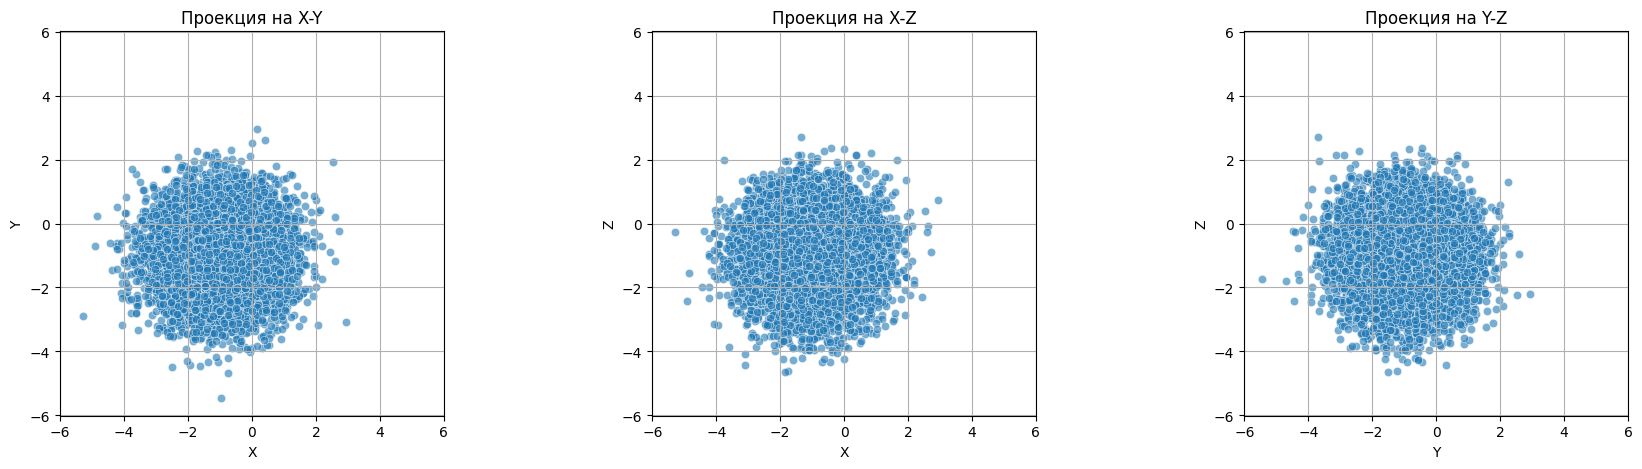

Ковариационная матрица:
 [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Направление главной оси (максимальной дисперсии): [0. 0. 0. 0. 1.]
Дисперсия вдоль этой оси (собственное значение): 1.00



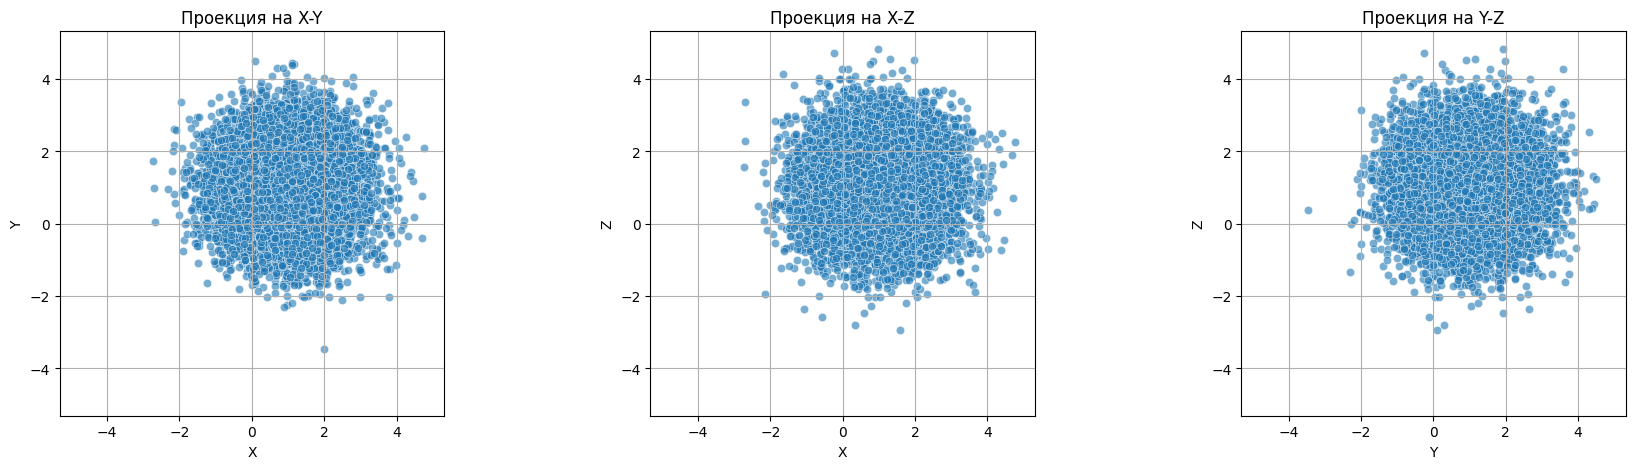

Гауссиана 0:
mean:  -1.0004209280014038
var:  1.0003397464752197
cnt:  10000
dim:  5

Гауссиана 1:
mean:  1.0023545026779175
var:  1.0033018589019775
cnt:  10000
dim:  5


In [4]:
# Генерация датасетов
dim = cfg.dim
x0_vars_diag = list(cfg.x0_vars_diag) * dim
x0_cov_pairs = list(cfg.x0_cov_pairs) * dim
x0_mean = list(cfg.x0_mean) * dim

x1_vars_diag = list(cfg.x1_vars_diag) * dim
x1_cov_pairs = list(cfg.x1_cov_pairs) * dim
x1_mean =list(cfg.x1_mean) * dim

# train
x0 = generate_gaussian_cloud(
    vars_diag=x0_vars_diag,  
    cov_pairs=x0_cov_pairs, 
    mean=x0_mean, 
    dataset_size=cfg.dataset_size, 
    plot=True
)  

x1 = generate_gaussian_cloud(
    vars_diag=x1_vars_diag,  
    cov_pairs=x1_cov_pairs, 
    mean=x1_mean, 
    dataset_size=cfg.dataset_size, 
    plot=True
)  


# test
x0_test = generate_gaussian_cloud(
    vars_diag=x0_vars_diag,  
    cov_pairs=x0_cov_pairs, 
    mean=x0_mean, 
    dataset_size=cfg.test_dataset_size, 
    plot=False
)  

x1_test = generate_gaussian_cloud(
    vars_diag=x1_vars_diag,  
    cov_pairs=x1_cov_pairs, 
    mean=x1_mean, 
    dataset_size=cfg.test_dataset_size, 
    plot=False
)  


# Приведение к требуемому типу
x0 = torch.tensor(x0).to(torch.float32).to(device)
x1 = torch.tensor(x1).to(torch.float32).to(device)
x0_test = torch.tensor(x0_test).to(torch.float32).to(device)
x1_test = torch.tensor(x1_test).to(torch.float32).to(device)

x_pairs = torch.stack([x0, x1], dim=1).to(device)
x_pairs_test = torch.stack([x0_test, x1_test], dim=1).to(device)


print('Гауссиана 0:')
print('mean: ', x0.mean().item())
print('var: ', x0.var().item())
print('cnt: ', x0.shape[0])
print('dim: ', x0.shape[1])

print('\nГауссиана 1:')
print('mean: ', x1.mean().item())
print('var: ', x1.var().item())
print('cnt: ', x1.shape[0])
print('dim: ', x1.shape[1])

## Инициализация модели

In [5]:
# Определение структуры модели

activation_fn = hydra.utils.get_class(cfg.activation_fn)()
hidden_size = cfg.net_hidden_layer_width
dim = cfg.dim
net_fn = partial(ScoreNetwork, input_dim=dim+1, layer_widths=[hidden_size, hidden_size, dim], activation_fn=activation_fn)  

num_steps = cfg.num_steps
sigma = cfg.sigma
inner_iters = cfg.inner_iters
batch_size = cfg.batch_size


model = DSBM(net_fwd=net_fn().to(device), 
             net_bwd=net_fn().to(device), 
             num_steps=num_steps, sig=sigma, first_coupling=cfg.first_coupling)
train_fn = train_dsbm

n_parameters = sum(p.numel() for p in model.net_fwd.parameters() if p.requires_grad)
print(f"Number of parameters: <{n_parameters}>")

Number of parameters: <4933>


## Preprocessing

In [6]:
# Нормализация данных

all_data = torch.stack([x0, x1], dim=1).to(device) # Формируем полный пулл данных, которые учитываем для обучения скалера
model.normalizer.fit(all_data)
model.normalizer_fitted = True # Флаг для модели, что задействован скалер
model.sig = sigma * model.normalizer.A # Масштабирем sigma
x0_norm= model.normalizer.normalize(x0.clone())
x1_norm = model.normalizer.normalize(x1.clone())
x_pairs = torch.stack([x0_norm, x1_norm], dim=1).to(device) # Формируем обучающую пару

print('Гауссиана 0:')
print('mean: ', x0_norm.mean().item())
print('var: ', x0_norm.var().item())
print('cnt: ', x0_norm.shape[0])
print('dim: ', x0_norm.shape[1])

print('\nГауссиана 1:')
print('mean: ', x1_norm.mean().item())
print('var: ', x1_norm.var().item())
print('cnt: ', x1_norm.shape[0])
print('dim: ', x1_norm.shape[1])

Гауссиана 0:
mean:  -0.13258551061153412
var:  0.03775046393275261
cnt:  10000
dim:  5

Гауссиана 1:
mean:  0.2564772665500641
var:  0.037862248718738556
cnt:  10000
dim:  5


In [7]:
logs = dict()
logs['optimal_result_dict'] = {'mean': x0_test.mean(0).mean(0).item(), 'var': x0_test.var(0).mean(0).item(), 'cov': (np.sqrt(5) - 1) / 2}
logs['time_list'] = []
logs['time_list_res'] = []
logs['result_list'] = {k: [] for k in logs['optimal_result_dict'].keys()}

## Train-test loops

In [8]:
# train-test
model, logs = train(cfg, model, x_pairs, x_pairs_test, logs, 2500, 1e-5, RESULT_DIR)

Training Loop iter:  20%|███████████▌                                               | 490/2500 [10:56<44:54,  1.34s/it]


KeyboardInterrupt: 

In [9]:
from src.wasserstein_distance import empirical_wasserstein_distance

In [10]:
#val
df_SWD = test_fn(cfg, model, N_samples = 10)
df_SWD

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Python\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.91s/it]


,sample_№,"inference_time, сек.",2-WD_opt,2-WD,"delta_W, %",mean_opt,mean,"delta_mean, %",var_opt,var,"delta_var, %",cov
0,0,0.536277,4.563956,4.558059,0.129222,-1.002683,-0.988382,1.426226,1.000517,1.056387,5.584081,0.630566
1,1,0.457933,4.537276,4.461573,1.668468,-1.002683,-0.984690,1.794454,1.000517,1.041009,4.047029,0.627406
2,2,0.499460,4.494898,4.474663,0.450179,-1.002683,-0.987264,1.537775,1.000517,1.046924,4.638275,0.623939
3,3,0.394321,4.563983,4.514550,1.083120,-1.002683,-0.996145,0.651995,1.000517,1.060437,5.988825,0.635781
4,4,0.534066,4.559511,4.476110,1.829160,-1.002683,-0.984663,1.797129,1.000517,1.048602,4.805987,0.627381
5,5,0.407901,4.548967,4.538939,0.220453,-1.002683,-0.991999,1.065483,1.000517,1.047540,4.699874,0.628886
6,6,0.465469,4.541445,4.523557,0.393871,-1.002683,-0.987150,1.549111,1.000517,1.057031,5.648444,0.636786
7,7,0.515770,4.506419,4.532635,0.581753,-1.002683,-0.998080,0.459071,1.000517,1.058206,5.765852,0.630264
8,8,0.481382,4.548527,4.510813,0.829152,-1.002683,-0.989344,1.330288,1.000517,1.042208,4.166903,0.625254
9,9,0.460017,4.551085,4.440938,2.420244,-1.002683,-0.981259,2.136620,1.000517,1.042392,4.185335,0.621879


In [12]:
df_SWD['2-WD_opt'] - df_SWD['2-WD']

0    0.005898
1    0.075703
2    0.020235
3    0.049433
4    0.083401
5    0.010028
6    0.017887
7   -0.026216
8    0.037714
9    0.110147
dtype: float64

# Сохранение результатов

In [14]:
# Сохраняем результаты
# Сохраняем последнюю версию модели
torch.save(model.state_dict(), RESULT_DIR + 'best_model.pt')

df_result = pd.DataFrame(logs['result_list'])
df_result.to_csv(RESULT_DIR + 'df_result.csv')
df_result.to_pickle(RESULT_DIR+ 'df_result.pkl')

df_time = pd.DataFrame(logs['time_list'])
df_time.to_csv(RESULT_DIR + 'df_time.csv')
df_time.to_pickle(RESULT_DIR+ 'df_time.pkl')

df_SWD.to_csv(RESULT_DIR + 'df_wasserstein_distance.csv')